In [7]:
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using CUDA # dont run unless you wanna install a  ton of stuff, takes a while too.
using CSV
using DataFrames

In [8]:
hasCUDA = false 
if CUDA.functional()
    println("GPU detected: $(CUDA.name(CUDA.device()))")
    hasCUDA = true
else
    println("NO CUDA GPU, wont run.")
    hasCUDA = false
end

GPU detected: NVIDIA GeForce RTX 3070 Ti Laptop GPU


true

In [ ]:
function GenRandUnitary(n)
    return Matrix(qr(rand(ComplexF64, 2^n, 2^n)).Q)
end

## Householder QR Algorithm from the course
https://jeremylt.github.io/csci-3656-fall-2025/notebooks/2025-09-29-Householder-QR.html

In [14]:
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        # Build v for the current column
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # Here's the fix!
        v = normalize(v)
        # Build and apply F
        R[j:end, j:end] -= 2 * v * (v' * R[j:end,j:end])
        # Keep track of the reflectors
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

In [15]:
function GetR_householder(R)
    return R
end

function GetQ_householder(V, m)
    Q = Matrix{ComplexF64}(I, m, m) # rebuild Q from reflectors
    
    # reflect in reverse order
    for j in length(V):-1:1
        v = V[j]
        v_full = zeros(ComplexF64, m) # v full size
        v_full[j:j+length(v)-1] = v
        
        # apply the reflection: Q = Q - 2*v*(v'*Q)
        Q = Q - 2 * v_full * (v_full' * Q)
    end
    
    return Q
end

function verify_qr_householder(A_OG, V, R)
    m, _ = size(A_OG)
    Q = GetQ_householder(V, m)
    R_matrix = GetR_householder(R)
    Result = Q * R_matrix
    success = A_OG ≈ Result
    if success == true
        println("passed")
    else
        println("failed")
    end
    return success
end

verify_qr_householder (generic function with 1 method)


CPU Benchmark (qr_householder):
n = 1 (CPU)
passed
n = 2 (CPU)
passed
n = 3 (CPU)
passed
n = 4 (CPU)
passed
n = 5 (CPU)
passed
n = 6 (CPU)
passed
n = 7 (CPU)
passed
n = 8 (CPU)
passed
n = 9 (CPU)
passed
n = 10 (CPU)
QR: 3.70159 seconds
passed
Verification: 6.057171 seconds
n = 11 (CPU)
Generation: 1.415775 seconds
QR: 51.907441 seconds
passed
Verification: 81.829919 seconds

GPU Benchmark (qr_householder):
n = 1 (GPU)
passed
n = 2 (GPU)
passed
n = 3 (GPU)
passed
n = 4 (GPU)
passed
n = 5 (GPU)
passed
n = 6 (GPU)
passed
n = 7 (GPU)
passed
n = 8 (GPU)
passed
n = 9 (GPU)
passed
n = 10 (GPU)
QR: 4.444778 seconds
passed
Verification: 7.025792 seconds
n = 11 (GPU)
Generation + Transfer: 1.390965 seconds
QR: 45.478878 seconds
passed
Verification: 84.655185 seconds

Results in qr_householder_benchmark_results.csv


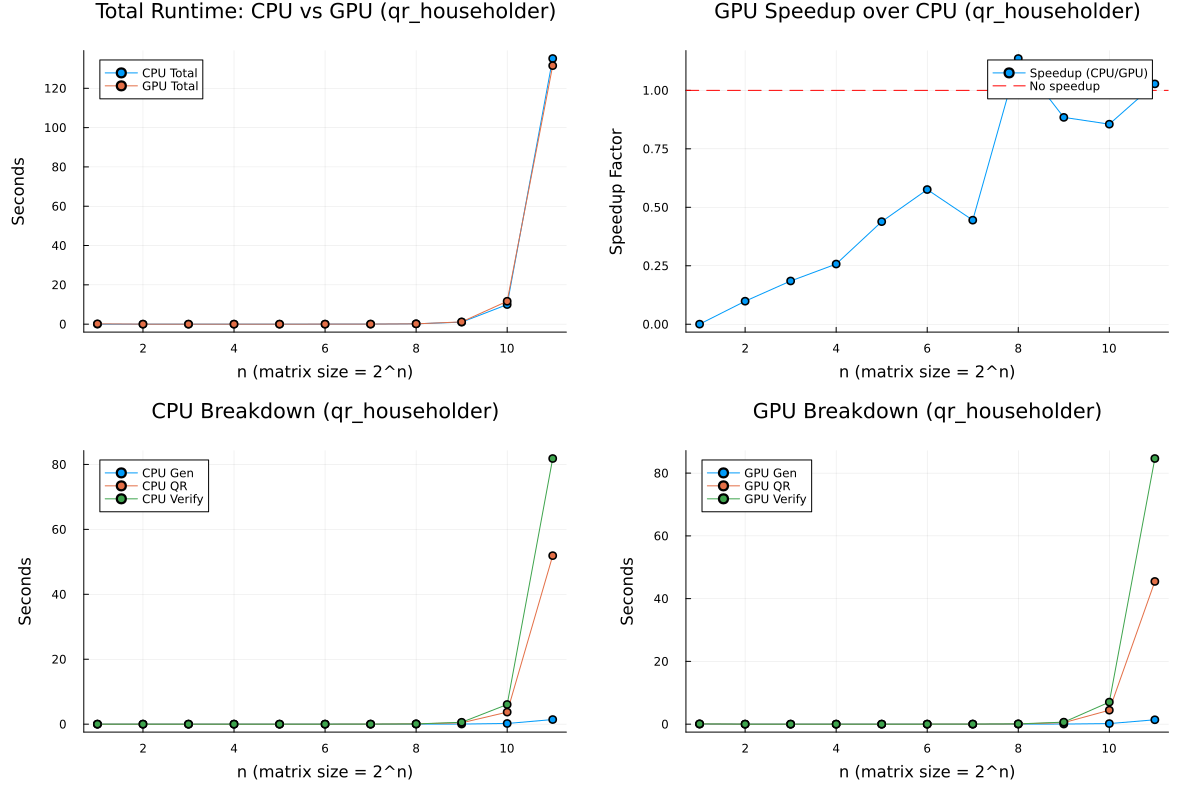

In [17]:
if hasCUDA == true
    
    n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    
    cpu_gen_times = Float64[]
    cpu_qr_times = Float64[]
    cpu_verify_times = Float64[]
    
    gpu_gen_times = Float64[]
    gpu_qr_times = Float64[]
    gpu_verify_times = Float64[]
    
    
    println("\nCPU Benchmark (qr_householder):")
    for n in n_values
        println("n = $n (CPU)")
        gen_time = @elapsed U = GenRandUnitary(n)
        if gen_time > 1.0
            println("Generation: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = deepcopy(U)
        qr_time = @elapsed V, R = qr_householder(U_copy)
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end
        
        verify_time = @elapsed verify_qr_householder(U, V, R)
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(cpu_gen_times, gen_time)
        push!(cpu_qr_times, qr_time)
        push!(cpu_verify_times, verify_time)
    end

    
    println("\nGPU Benchmark (qr_householder):")
    for n in n_values
        println("n = $n (GPU)")
        
        gen_time = @elapsed begin
            U_cpu = GenRandUnitary(n)
            U = CuArray(U_cpu)
            CUDA.synchronize()
        end
        
        if gen_time > 1.0
            println("Generation + Transfer: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = copy(U)
        
        qr_time = @elapsed begin
            A = CuArray(Array(U_copy))
            A_cpu = Array(A)
            V, R = qr_householder(A_cpu)
            V_gpu = [CuArray(v) for v in V]
            R_gpu = CuArray(R)
            CUDA.synchronize()
        end
        
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end

        
        verify_time = @elapsed begin
            U_verify = Array(U)
            V_verify = [Array(v) for v in V_gpu]
            R_verify = Array(R_gpu)
            verify_qr_householder(U_verify, V_verify, R_verify)
        end
        
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(gpu_gen_times, gen_time)
        push!(gpu_qr_times, qr_time)
        push!(gpu_verify_times, verify_time)
    end
    
    
    cpu_total_times = cpu_gen_times .+ cpu_qr_times .+ cpu_verify_times
    gpu_total_times = gpu_gen_times .+ gpu_qr_times .+ gpu_verify_times

    
    df = DataFrame(
        n = n_values,
        matrix_size = [2^n for n in n_values],
        cpu_gen = cpu_gen_times,
        cpu_qr = cpu_qr_times,
        cpu_verify = cpu_verify_times,
        cpu_total = cpu_total_times,
        gpu_gen = gpu_gen_times,
        gpu_qr = gpu_qr_times,
        gpu_verify = gpu_verify_times,
        gpu_total = gpu_total_times,
        speedup = cpu_total_times ./ gpu_total_times
    )
    
    CSV.write("qr_householder_benchmark_results.csv", df)
    println("\nResults in qr_householder_benchmark_results.csv")
    
    
    p1 = plot(n_values, [cpu_total_times gpu_total_times],
              label=["CPU Total" "GPU Total"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="Total Runtime: CPU vs GPU (qr_householder)",
              marker=:circle,
              legend=:topleft)
    
    p2 = plot(n_values, cpu_total_times ./ gpu_total_times,
              label="Speedup (CPU/GPU)",
              xlabel="n (matrix size = 2^n)",
              ylabel="Speedup Factor",
              title="GPU Speedup over CPU (qr_householder)",
              marker=:circle,
              legend=:topright)
    hline!([1.0], label="No speedup", linestyle=:dash, color=:red)
    
    p3 = plot(n_values, [cpu_gen_times cpu_qr_times cpu_verify_times],
              label=["CPU Gen" "CPU QR" "CPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="CPU Breakdown (qr_householder)",
              marker=:circle,
              legend=:topleft)
    
    p4 = plot(n_values, [gpu_gen_times gpu_qr_times gpu_verify_times],
              label=["GPU Gen" "GPU QR" "GPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="GPU Breakdown (qr_householder)",
              marker=:circle,
              legend=:topleft)
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(1200, 800), margin=6mm)
end

## The New QR Algorithm from the paper
The step we use is given by $$A(nb+1:n,nb+1:n)\leftarrow A(nb+1:n, nb+1:n)-A(nb+1:n,1:nb)\times A(1:nb,nb+1:n)$$

https://arxiv.org/pdf/2004.07710


In [18]:
function NewHouseholderQR(A)
    n,_ = size(A)
    Tau = zeros(ComplexF64, n-1)
    for nb in 1:(n-1)
        phase = A[nb,nb]/abs(A[nb,nb])
        Tau[nb] = (1+abs(A[nb, nb]))
        A[nb, nb] += phase
        A[nb:n, nb] = A[nb:n, nb]/(phase*Tau[nb])
        A[nb,nb] = -phase
        A[nb+1:n,nb+1:n]= A[nb+1:n, nb+1:n]-A[nb+1:n,nb].*A[nb:nb, nb+1:n]
    end
    A, Tau
end


NewHouseholderQR (generic function with 1 method)

In [19]:
function verify_qr(A_OG, A_Factor, Tau) # function for easy verification
    B= deepcopy(A_Factor)

    Q = GetQ(B, Tau)
    R = GetR(B, Tau)
    Result=(Q*R)
    success = A_OG ≈Result

    if success ==true
        println("passed") # lowkey unsure if this should print this, kinda annoying
    else
        println("failed")
    end
    return success
end

function GetR(A, Tau)
    diagm(0 => diag(A, 0))
end

function GetQ(A, Tau)
    n, _ = size(A)
    Q = diagm(ones(ComplexF64, n))
    for i in n-1:-1:1
        u = A[i:n, i]
        u[1] = 1
        Q[i:n, :] = Q[i:n, :] - Tau[i] * u * (u' * Q[i:n, :])
    end
    Q
end

GetQ (generic function with 1 method)

## Running the same benchmark as the algo from class


CPU Benchmark (NewHouseholderQR):
n = 1 (CPU)
passed
n = 2 (CPU)
passed
n = 3 (CPU)
passed
n = 4 (CPU)
passed
n = 5 (CPU)
passed
n = 6 (CPU)
passed
n = 7 (CPU)
passed
n = 8 (CPU)
passed
n = 9 (CPU)
passed
n = 10 (CPU)
QR: 2.626346 seconds
passed
Verification: 6.100005 seconds
n = 11 (CPU)
Generation: 1.293989 seconds
QR: 30.79088 seconds
passed
Verification: 75.487786 seconds

GPU Benchmark (NewHouseholderQR):
n = 1 (GPU)
passed
n = 2 (GPU)
passed
n = 3 (GPU)
passed
n = 4 (GPU)
passed
n = 5 (GPU)
passed
n = 6 (GPU)
passed
n = 7 (GPU)
passed
n = 8 (GPU)
passed
n = 9 (GPU)
passed
n = 10 (GPU)
QR: 2.388064 seconds
passed
Verification: 6.03814 seconds
n = 11 (GPU)
Generation + Transfer: 1.450514 seconds
QR: 30.143309 seconds
passed
Verification: 69.854743 seconds

Results in NewHouseholderQR_benchmark_results.csv


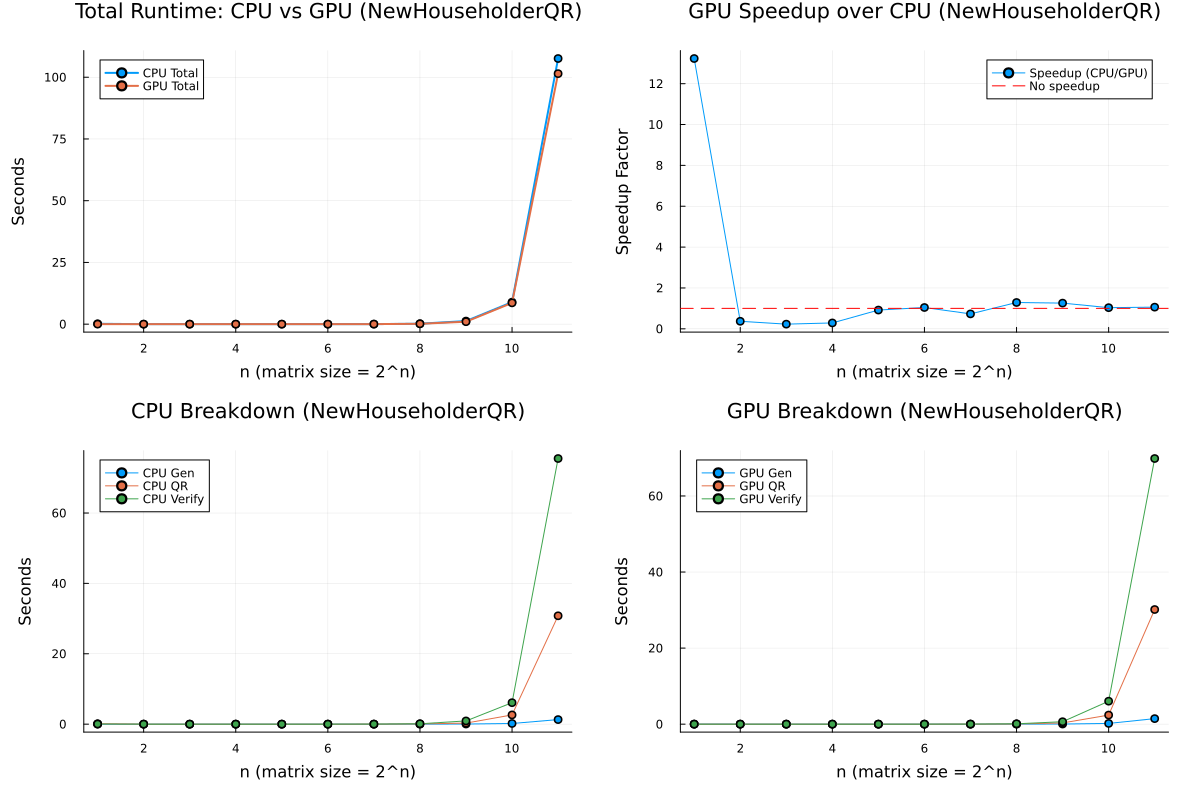

In [20]:
if hasCUDA == true
    
    n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] # biggest is 2048 x 2048, if you want more sacrifice ur own runtime/life
    
    # on dat cpu timing
    new_cpu_gen_times = Float64[]
    new_cpu_qr_times = Float64[]
    new_cpu_verify_times = Float64[]
    
    # gpu timing
    new_gpu_gen_times = Float64[]
    new_gpu_qr_times = Float64[]
    new_gpu_verify_times = Float64[]
    
    
    println("\nCPU Benchmark (NewHouseholderQR):")
    for n in n_values
        println("n = $n (CPU)")
        gen_time = @elapsed U = GenRandUnitary(n)
        if gen_time > 1.0
            println("Generation: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = deepcopy(U)
        qr_time = @elapsed A, Tau = NewHouseholderQR(U_copy)
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end
        
        verify_time = @elapsed verify_qr(U, A, Tau)
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(new_cpu_gen_times, gen_time)
        push!(new_cpu_qr_times, qr_time)
        push!(new_cpu_verify_times, verify_time)
    end

    
    println("\nGPU Benchmark (NewHouseholderQR):")
    for n in n_values
        println("n = $n (GPU)")
        
        # generaitng a random unitary matrix uses cpu op, so gen on there then transfer to gpu.
        gen_time = @elapsed begin
            U_cpu = GenRandUnitary(n)
            U = CuArray(U_cpu)
            CUDA.synchronize()
        end
        
        if gen_time > 1.0
            println("Generation + Transfer: $(round(gen_time, digits=6)) seconds")
        end
        
        U_copy = copy(U)
        
        qr_time = @elapsed begin
            A = CuArray(Array(U_copy))  # Convert back and forth to ensure proper handling
            A_cpu = Array(A)
            A_result, Tau = NewHouseholderQR(A_cpu)
            A = CuArray(A_result)
            Tau_gpu = CuArray(Tau)
            CUDA.synchronize()
        end
        
        if qr_time > 1.0
            println("QR: $(round(qr_time, digits=6)) seconds")
        end

        
        verify_time = @elapsed begin
            U_verify = Array(U)
            A_verify = Array(A)
            Tau_verify = Array(Tau_gpu)
            verify_qr(U_verify, A_verify, Tau_verify)
        end
        
        if verify_time > 1.0
            println("Verification: $(round(verify_time, digits=6)) seconds")
        end
        
        push!(new_gpu_gen_times, gen_time)
        push!(new_gpu_qr_times, qr_time)
        push!(new_gpu_verify_times, verify_time)
    end
    
    
    new_cpu_total_times = new_cpu_gen_times .+ new_cpu_qr_times .+ new_cpu_verify_times
    new_gpu_total_times = new_gpu_gen_times .+ new_gpu_qr_times .+ new_gpu_verify_times # get the total times for both

    
    # DATAFRAME to export to a csv, cuz why not.
    new_df = DataFrame(
        n = n_values,
        matrix_size = [2^n for n in n_values],
        cpu_gen = new_cpu_gen_times,
        cpu_qr = new_cpu_qr_times,
        cpu_verify = new_cpu_verify_times,
        cpu_total = new_cpu_total_times,
        gpu_gen = new_gpu_gen_times,
        gpu_qr = new_gpu_qr_times,
        gpu_verify = new_gpu_verify_times,
        gpu_total = new_gpu_total_times,
        speedup = new_cpu_total_times ./ new_gpu_total_times
    ) # This can be deleted , was doing it so i can see the exact times. i dont think its neccesarry for the reqs tho
    
    CSV.write("NewHouseholderQR_benchmark_results.csv", new_df) # same as above ^^
    println("\nResults in NewHouseholderQR_benchmark_results.csv")
    
    

    # plethora of plots, prolly dont need all. 
    p1 = plot(n_values, [new_cpu_total_times new_gpu_total_times],
              label=["CPU Total" "GPU Total"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="Total Runtime: CPU vs GPU (NewHouseholderQR)",
              lw=2,
              marker=:circle,
              legend=:topleft)
    
    p2 = plot(n_values, new_cpu_total_times ./ new_gpu_total_times,
              label="Speedup (CPU/GPU)",
              xlabel="n (matrix size = 2^n)",
              ylabel="Speedup Factor",
              title="GPU Speedup over CPU (NewHouseholderQR)",
              marker=:circle,
              legend=:topright)
    hline!([1.0], label="No speedup", linestyle=:dash, color=:red)
    
    p3 = plot(n_values, [new_cpu_gen_times new_cpu_qr_times new_cpu_verify_times],
              label=["CPU Gen" "CPU QR" "CPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="CPU Breakdown (NewHouseholderQR)",
              marker=:circle,
              legend=:topleft)
    
    p4 = plot(n_values, [new_gpu_gen_times new_gpu_qr_times new_gpu_verify_times],
              label=["GPU Gen" "GPU QR" "GPU Verify"],
              xlabel="n (matrix size = 2^n)",
              ylabel="Seconds",
              title="GPU Breakdown (NewHouseholderQR)",
              marker=:circle,
              legend=:topleft)
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(1200, 800), margin=6mm)

end


 Comparison: qr_householder vs NewHouseholderQR



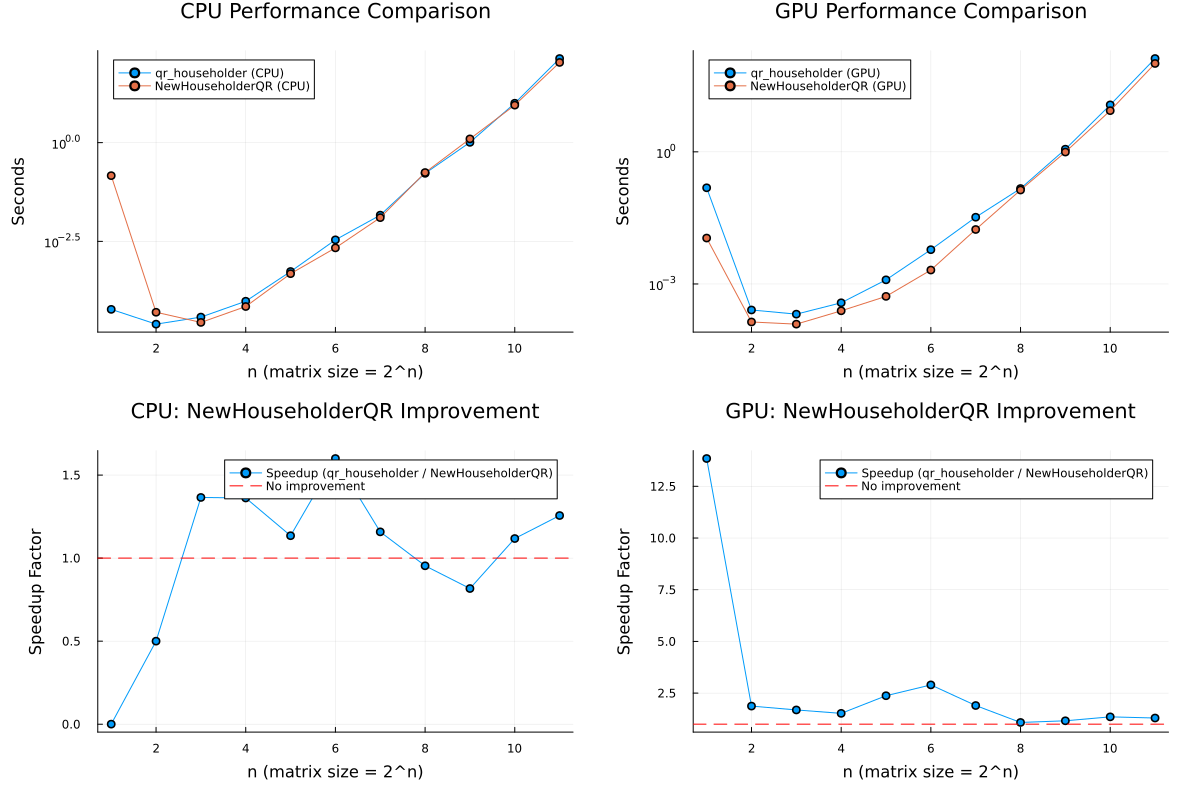

In [21]:
println("\n Comparison: qr_householder vs NewHouseholderQR\n")

# comparison plots
c1 = plot(n_values, [cpu_total_times new_cpu_total_times],
          label=["qr_householder (CPU)" "NewHouseholderQR (CPU)"],
          xlabel="n (matrix size = 2^n)",
          ylabel="Seconds",
          title="CPU Performance Comparison",
          marker=:circle,
          legend=:topleft,
          yscale=:log10)

c2 = plot(n_values, [gpu_total_times new_gpu_total_times],
          label=["qr_householder (GPU)" "NewHouseholderQR (GPU)"],
          xlabel="n (matrix size = 2^n)",
          ylabel="Seconds",
          title="GPU Performance Comparison",
          marker=:circle,
          legend=:topleft,
          yscale=:log10)

c3 = plot(n_values, cpu_total_times ./ new_cpu_total_times,
          label="Speedup (qr_householder / NewHouseholderQR)",
          xlabel="n (matrix size = 2^n)",
          ylabel="Speedup Factor",
          title="CPU: NewHouseholderQR Improvement",
          marker=:circle,
          legend=:topright)
hline!([1.0], label="No improvement", linestyle=:dash, color=:red)

c4 = plot(n_values, gpu_total_times ./ new_gpu_total_times,
          label="Speedup (qr_householder / NewHouseholderQR)",
          xlabel="n (matrix size = 2^n)",
          ylabel="Speedup Factor",
          title="GPU: NewHouseholderQR Improvement",
          marker=:circle,
          legend=:topright)
hline!([1.0], label="No improvement", linestyle=:dash, color=:red)

plot(c1, c2, c3, c4, layout=(2,2), size=(1200, 800), margin=6mm)


## We were unable to finish implementing the suggested changes in the paper to get to BLAS 3 
Using these new update relations we can improve the algorithm by three means:

• first we can improve the unblocked algorithm. Instead of updating the whole matrix at
each iteration with a rank one update we only update one row and one column : at the k-th
iteration we have computed the k-th Householder vector and we update the row A(k +
1, k + 1 : n) and the column A(k + 1 : n, k + 1) via the relations (9) and (10). Such updates
consist in more and bigger matrix-vector operations and experimentally it appears to scale
better.

• Secondly this naturally leads to a blocked version of the algorithm. Let nb be the size of our
block. Once we have done the computations on the first nb rows and nb columns of A with
an unblocked version, we can update the rest of the matrix with a matrix/matrix product
via equation (11) and continue the algorithm on the matrix A(nb + 1 : n, nb + 1 : n) until
we reach the last block where the unblocked algorithm is applied.

• A third improvement can be made in order to avoid using the unblocked algorithm to
compute the full panel of nb rows and columns of A. Indeed the update of the blocks
A(nb+1:n, 1:nb) and A(1:nb, nb+1:n) can be performed with BLAS 3 operations.
One can prove that there exist triangular matrices T i
1, T i
2 of size i × i, i = 1..nb such that

### TS hard man